# YouTube, desktop, фильтрованные трассы с учётом времени

In [1]:
import os
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

**Подгружаем таблицу с нашими данными**

In [2]:
data = pd.read_csv('data_unfiltered.csv')
data

,Unnamed: 0,Video_number,Density_burst,Density_throttling,Quality
0,0,1,1.058198e+07,7.784370e+05,2160
1,1,2,1.455325e+07,8.185857e+05,2160
2,2,3,1.446529e+07,1.205208e+06,2160
3,3,4,1.098314e+07,1.508179e+06,2160
4,4,5,5.832415e+06,7.187604e+05,2160
...,...,...,...,...,...
145,145,21,2.051503e+06,4.545315e+04,360
146,146,22,1.284383e+06,3.662261e+04,360
147,147,23,1.070837e+06,2.868816e+04,360
148,148,24,1.415124e+06,3.507011e+04,360


In [3]:
data = data.drop(columns=['Unnamed: 0', 'Video_number'])
data

,Density_burst,Density_throttling,Quality
0,1.058198e+07,7.784370e+05,2160
1,1.455325e+07,8.185857e+05,2160
2,1.446529e+07,1.205208e+06,2160
3,1.098314e+07,1.508179e+06,2160
4,5.832415e+06,7.187604e+05,2160
...,...,...,...
145,2.051503e+06,4.545315e+04,360
146,1.284383e+06,3.662261e+04,360
147,1.070837e+06,2.868816e+04,360
148,1.415124e+06,3.507011e+04,360


**Посмотрим на данные наглядно**

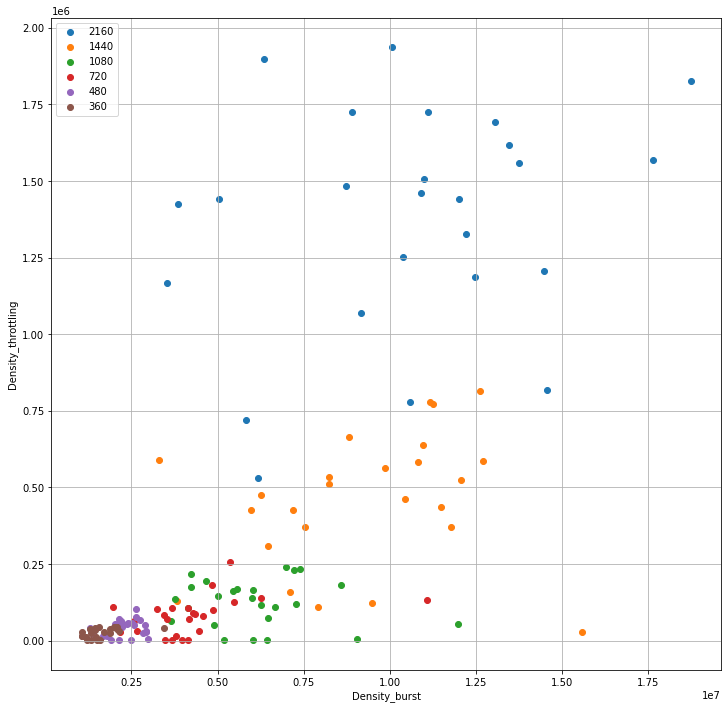

In [4]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)

for quality in [2160, 1440, 1080, 720, 480, 360]:
    x = []
    y = []
    for i in range(len(data)):
        if data['Quality'][i] == quality:
            x.append(data['Density_burst'][i])
            y.append(data['Density_throttling'][i])
    plt.scatter(x, y, label=quality)
    
plt.xlabel("Density_burst")
plt.ylabel("Density_throttling")
plt.legend()
plt.grid(True)

plt.show()

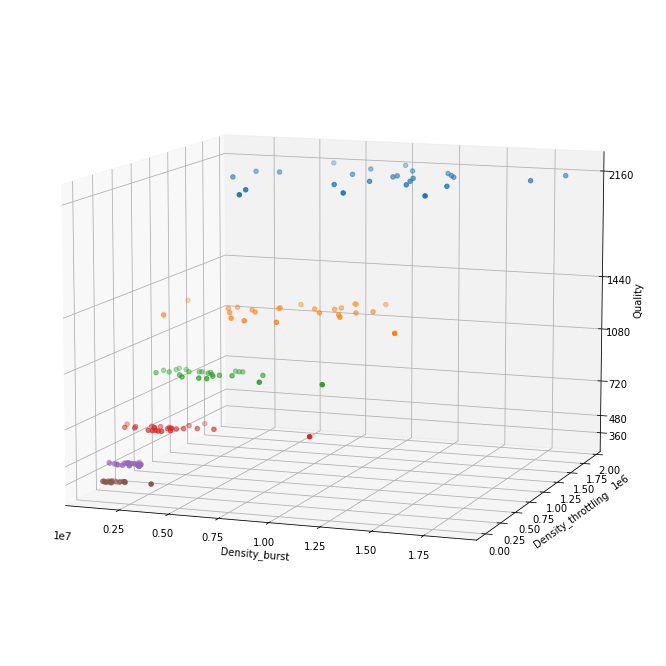

In [5]:
fig_3d = plt.figure(figsize=(12, 12))
ax = fig_3d.add_subplot(projection='3d')

for quality in [2160, 1440, 1080, 720, 480, 360]:
    x = []
    y = []
    z = []
    for i in range(len(data)):
        if data['Quality'][i] == quality:
            x.append(data['Density_burst'][i])
            y.append(data['Density_throttling'][i])
            z.append(quality)
    ax.scatter(x, y, z)
    
ax.set_xlabel('Density_burst')
ax.set_ylabel('Density_throttling')
ax.set_zlabel('Quality')

ax.view_init(10,-70)

ax.set_zticks([360, 480, 720, 1080, 1440, 2160])

plt.grid(True)

plt.show()

**Перемешаем строки**

In [6]:
data_shuffled = shuffle(data)
data_shuffled

,Density_burst,Density_throttling,Quality
23,1.201174e+07,1.442586e+06,2160
111,2.581793e+06,5.062330e+04,480
137,1.443721e+06,3.403647e+04,360
125,1.318803e+06,1.061088e+03,360
8,1.221661e+07,1.327151e+06,2160
...,...,...,...
126,1.219965e+06,1.976430e+03,360
30,1.043596e+07,4.634110e+05,1440
148,1.415124e+06,3.507011e+04,360
66,4.242477e+06,2.184809e+05,1080


**Пробуем обычный KNN**

In [7]:
X = data_shuffled[['Density_burst', 'Density_throttling']]
y = data_shuffled['Quality']

best_score = 0.0
i_best_score = 0
for i in range(1, 30):
    model = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(model, X, y, cv=10, scoring = 'accuracy')
    n_spaces = 1 - i // 10
    print(i, ' ' * n_spaces, scores.mean())
    if (scores.mean() > best_score):
        best_score = scores.mean()
        i_best_score = i

print("\nЛучший резульат:\nn =", i_best_score, "\naccuracy =", best_score)

1   0.6066666666666667
2   0.6133333333333333
3   0.6599999999999999
4   0.6599999999999999
5   0.6466666666666667
6   0.6333333333333333
7   0.62
8   0.6066666666666667
9   0.6466666666666667
10  0.5866666666666667
11  0.5800000000000001
12  0.6066666666666667
13  0.5866666666666667
14  0.5733333333333334
15  0.5933333333333333
16  0.6199999999999999
17  0.5733333333333333
18  0.5999999999999999
19  0.58
20  0.58
21  0.5933333333333334
22  0.5866666666666667
23  0.5866666666666667
24  0.5733333333333333
25  0.58
26  0.58
27  0.5666666666666667
28  0.5599999999999999
29  0.5599999999999999

Лучший резульат:
n = 3 
accuracy = 0.6599999999999999


**Нужно нормализовать данные**

In [8]:
data_norm = data_shuffled.copy()

for column in ['Density_burst', 'Density_throttling']:
    data_norm[column] = ((data_norm[column] - data_norm[column].min()) /
                            (data_norm[column].max() - data_norm[column].min()))
    
data_norm

,Density_burst,Density_throttling,Quality
23,0.619675,0.744689,2160
111,0.086025,0.025610,480
137,0.021621,0.017041,360
125,0.014551,0.000006,360
8,0.631269,0.685056,2160
...,...,...,...
126,0.008958,0.000479,360
30,0.530500,0.238853,1440
148,0.020002,0.017575,360
66,0.180005,0.112324,1080


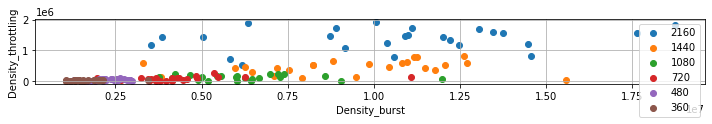

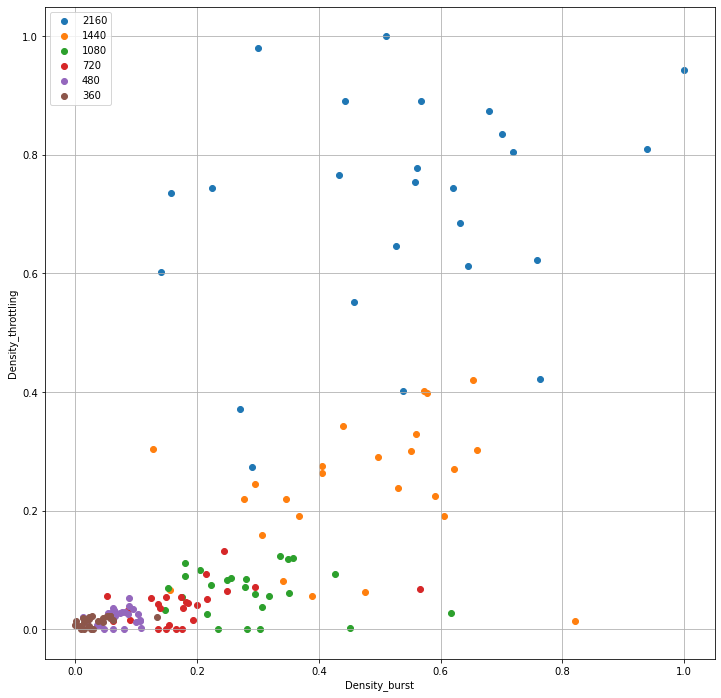

In [9]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(1.2)

for quality in [2160, 1440, 1080, 720, 480, 360]:
    x = []
    y = []
    for i in range(len(data)):
        if data['Quality'][i] == quality:
            x.append(data['Density_burst'][i])
            y.append(data['Density_throttling'][i])
    plt.scatter(x, y, label=quality)
    
plt.xlabel("Density_burst")
plt.ylabel("Density_throttling")
plt.legend()
plt.grid(True)

plt.show()

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)

for quality in [2160, 1440, 1080, 720, 480, 360]:
    x = []
    y = []
    for i in range(len(data_norm)):
        if data['Quality'][i] == quality:
            x.append(data_norm['Density_burst'][i])
            y.append(data_norm['Density_throttling'][i])
    plt.scatter(x, y, label=quality)
    
plt.xlabel("Density_burst")
plt.ylabel("Density_throttling")
plt.legend()
plt.grid(True)

plt.show()

*По графикам можно понять отличие работы классификаторов с нормализацией и без*

**Снова пробуем KNN, но теперь с нормализованными данными**

In [10]:
X = data_norm[['Density_burst', 'Density_throttling']]
y = data_norm['Quality']

best_score = 0.0
i_best_score = 0
for i in range(1, 30):
    model = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(model, X, y, cv=10, scoring = 'accuracy')
    n_spaces = 1 - i // 10
    print(i, ' ' * n_spaces, scores.mean())
    if (scores.mean() > best_score):
        best_score = scores.mean()
        i_best_score = i

print("\nЛучший резульат:\nn =", i_best_score, "\naccuracy =", best_score)

1   0.7133333333333333
2   0.7066666666666667
3   0.74
4   0.7733333333333333
5   0.7533333333333333
6   0.7533333333333333
7   0.7733333333333334
8   0.7666666666666668
9   0.7666666666666668
10  0.7333333333333332
11  0.74
12  0.7199999999999999
13  0.7266666666666667
14  0.7266666666666667
15  0.72
16  0.7
17  0.6866666666666666
18  0.6933333333333332
19  0.6866666666666666
20  0.7
21  0.7066666666666667
22  0.7133333333333333
23  0.7066666666666666
24  0.7
25  0.7
26  0.7
27  0.7066666666666667
28  0.7066666666666667
29  0.6799999999999999

Лучший резульат:
n = 7 
accuracy = 0.7733333333333334


*По сравнению с ненормированным KNN точность увеличилась значительно — 0.77 против 0.66*

**Пробуем Support Vector Classification**

In [11]:
best_score = 0.0
best_kernel = ''
for i_kernel in (['linear', 'poly', 'rbf', 'sigmoid']):
    X_norm = data_norm[['Density_burst', 'Density_throttling']]
    y_norm = data_norm['Quality']
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel=i_kernel))
    scores = cross_val_score(clf, X_norm, y_norm, cv=10, scoring = 'accuracy')
    n_spaces = 8 - len(i_kernel)
    print('kernel:', i_kernel, ' ' * n_spaces, 'scores_mean:', scores.mean())
    if (scores.mean() > best_score):
        best_score = scores.mean()
        best_kernel = i_kernel
        
print("\nЛучший резульат:\nkernel = ", best_kernel, "\naccuracy = ", best_score)

kernel: linear    scores_mean: 0.7266666666666666
kernel: poly      scores_mean: 0.5599999999999999
kernel: rbf       scores_mean: 0.7266666666666667
kernel: sigmoid   scores_mean: 0.42666666666666664

Лучший резульат:
kernel =  rbf 
accuracy =  0.7266666666666667


*Получаем более слабый, чем для KNN, результат*

**Пробуем CatBoost**

In [12]:
best_score = 0.0
best_params = []
for iter_param in ([100, 200, 500, 1000, 2000]):
    for cv_param in ([5, 10, 20]):
        for lr_param in ([0.05, 0.2, 0.5, 0.7, 1]):
            model = CatBoostClassifier(iterations=iter_param, learning_rate = lr_param, silent=True)
            scores = cross_val_score(model, X, y, cv=cv_param, scoring = 'accuracy')
            n_spaces_i = 1 - iter_param // 1000
            n_spaces_j = 1 - cv_param // 10
            n_spaces_k = 5 - len(str(lr_param))
            print('iterations:', iter_param, ' ' * n_spaces_i,
                  'cv:', cv_param, ' ' * n_spaces_j,
                  'learning_rate:', lr_param,' ' * n_spaces_k,
                  'scores_mean:', scores.mean())
            if (scores.mean() > best_score):
                best_score = scores.mean()
                best_params = [iter_param, cv_param, lr_param]

print("\nЛучший резульат:",
      "\niterations = ", best_params[0],
      "\ncv = ", best_params[1],
      "\nlearning_rate = ", best_params[2],
      "\naccuracy = ", best_score, sep = "")

iterations: 100   cv: 5   learning_rate: 0.05   scores_mean: 0.7733333333333334
iterations: 100   cv: 5   learning_rate: 0.2    scores_mean: 0.7866666666666667
iterations: 100   cv: 5   learning_rate: 0.5    scores_mean: 0.7266666666666666
iterations: 100   cv: 5   learning_rate: 0.7    scores_mean: 0.7133333333333333
iterations: 100   cv: 5   learning_rate: 1      scores_mean: 0.7133333333333332
iterations: 100   cv: 10  learning_rate: 0.05   scores_mean: 0.7533333333333333
iterations: 100   cv: 10  learning_rate: 0.2    scores_mean: 0.7466666666666667
iterations: 100   cv: 10  learning_rate: 0.5    scores_mean: 0.7266666666666666
iterations: 100   cv: 10  learning_rate: 0.7    scores_mean: 0.7333333333333334
iterations: 100   cv: 10  learning_rate: 1      scores_mean: 0.7133333333333333
iterations: 100   cv: 20  learning_rate: 0.05   scores_mean: 0.7651785714285714
iterations: 100   cv: 20  learning_rate: 0.2    scores_mean: 0.7794642857142857
iterations: 100   cv: 20  learning_rate:

*Получили лучший результат на данном эксперименте — 0.7866666666666667*